In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

C:\Users\vinay\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import zipfile

# Specify the path to the zip archive
zip_file_path = "book-crossings.zip"

# Specify the directory where you want to extract the contents
extracted_dir = "D:\studies\Projects\KNN_Book_recom_system"

# Extract the contents of the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print("Zip archive extracted successfully.")

Zip archive extracted successfully.


In [3]:
# get data files
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [4]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [5]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [6]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


<AxesSubplot:xlabel='user', ylabel='rating_log10'>

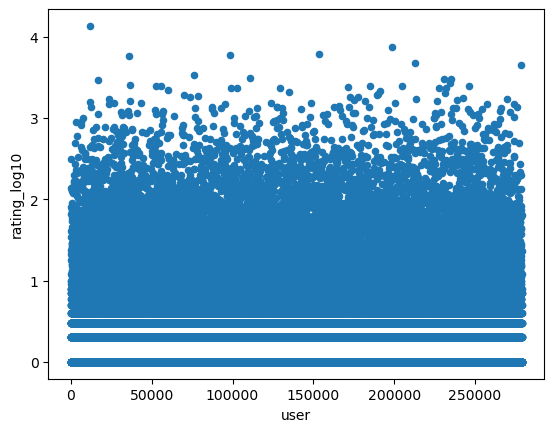

In [7]:
df = df_ratings[["user", "rating"]].groupby(["user"]).count().reset_index()

df['rating_log10'] = np.log10(df['rating'])
df.plot.scatter(x="user", y="rating_log10")

In [8]:
dfb = df_ratings.groupby(["isbn"]).count().reset_index()
good_books = dfb.loc[dfb["rating"] >= 100]["isbn"]

# books contains those have no less than 100 ratings
good_books = df_books.loc[df_books["isbn"].isin(good_books)]

In [9]:
dfu = df_ratings[["user", "rating"]]\
    .groupby(["user"])\
    .count()\
    .reset_index()

good_users = dfu.loc[dfu["rating"] >= 200]["user"]

df = df_ratings.loc[df_ratings["user"].isin(good_users)]
df = df.loc[df["isbn"].isin(good_books["isbn"])]

In [10]:
# pivot ratings into book features
df_book_features = df.pivot(
    index='isbn',
    columns='user',
    values='rating'
).fillna(0)

# convert dataframe of book features to scipy sparse matrix
# this part requires a lot of memory!
mat_book_features = csr_matrix(df_book_features.values)


In [11]:
model = NearestNeighbors(metric='cosine')
model.fit(mat_book_features)

NearestNeighbors(metric='cosine')

In [12]:
df_book_features.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# function to return recommended books - this will be tested
def get_recommends(title = ""):
    try:
        book = good_books.loc[good_books["title"] == title]
    except KeyError as e:
        print('Book', e, 'does not exist')
        return

    b = df_book_features.loc[df_book_features.index.isin(book["isbn"])]
    distance, indice = model.kneighbors([x for x in b.values], n_neighbors=5)

    distance =  distance[0][1:]
    indice = indice[0][1:]

    titles = [
        df_books.loc[df_books['isbn'] == df_book_features.iloc[i].name]["title"].values[0]\
        for i in indice
    ]

    recommended = [list(z) for z in zip(titles, distance)][::-1]
    return [title, recommended]

get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

In [14]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books) 


def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉


In [16]:
# Assuming you have 'df' (filtered ratings data), 'model' (trained KNN model), and 'df_book_features' (book features matrix)

from sklearn.metrics import mean_absolute_error

def calculate_accuracy():
    actual_ratings = []  # List to store actual ratings or interactions
    predicted_ratings = []  # List to store predicted ratings or interactions

    for user_id in df['user'].unique():
        # Get user's actual ratings or interactions from the ratings data
        user_ratings = df[df['user'] == user_id]
        user_actual_ratings = user_ratings.set_index('isbn')['rating']

        for isbn, rating in user_actual_ratings.items():
            # Get the index of the book in the book features matrix
            book_idx = df_book_features.index.get_loc(isbn)
            
            # Find nearest neighbors and distances for the book
            _, indices = model.kneighbors(df_book_features.iloc[book_idx].values.reshape(1, -1))
            
            # Calculate the predicted rating as the average rating of nearest neighbors
            predicted_rating = df.iloc[indices[0]].set_index('user')['rating'].mean()
            
            actual_ratings.append(rating)
            predicted_ratings.append(predicted_rating)

    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    return mae

# Calculate and print the MAE as a measure of accuracy
accuracy = calculate_accuracy()
print("Mean Absolute Error (MAE):", accuracy)
